In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [3]:
num_simu = 20 # number of total simulations, smaller number for testing, larger number for data generation.
#np.random.seed(69420)

In [4]:
######## Farm properties ########
# set number of species and flocks
num_flocks = 1 # One single flock, need to reflect in parameter matrices 
num_species = 4 # chicken, duck, vaccinated chicken, vaccinated duck

tot_no_bird = 200 # total number of birds in a flock

tot_chicken_popul = 100  # total chicken population
tot_duck_popul = tot_no_bird - tot_chicken_popul # total duck population


In [5]:
######## List of parameters ########
# Here we may adjust the key parameters for the simulation

chicken_to_chicken_transmission_rate = 1.23
chicken_latency_period = 0.24
chicken_infectious_period = 2.1

chicken_symptomatic_probability = 1
chicken_case_fatality_probability = 1

symptomatic_duck_to_duck_transmission_rate = 4.1
duck_latency_period = 0.12
symptomatic_duck_infectious_period = 4.3

duck_symptomatic_probability = 0.05 # <---- sensitvity needed
symptomatic_duck_case_fatality_probability = 0.1 # <---- sensitivity needed

asymptomatic_duck_to_duck_transmission_rate = \
        1/3 * symptomatic_duck_to_duck_transmission_rate # <---- sensitvity needed
asymptomatic_duck_infectious_period = \
        3 * symptomatic_duck_infectious_period # <---- sensitvity needed

asymptomatic_duck_case_fatality_probability = 0

chicken_to_duck_transmission_rate = symptomatic_duck_to_duck_transmission_rate
symptomatic_duck_to_chicken_transmission_rate = chicken_to_chicken_transmission_rate
asymptomatic_duck_to_chicken_transmission_rate = asymptomatic_duck_to_duck_transmission_rate \
                                                 * chicken_to_chicken_transmission_rate \
                                                 / symptomatic_duck_to_duck_transmission_rate


In [6]:
# initialise the infection rate tensor

# beta, beta_asym format: (infecting bird flock, infecting bird type, infected bird flock, infected bird type)
beta = np.zeros((num_flocks, num_species, num_flocks, num_species))
beta[:, 0, :, 0] = chicken_to_chicken_transmission_rate
beta[:, 1, :, 1] = symptomatic_duck_to_duck_transmission_rate
beta[:, 0, :, 1] = chicken_to_duck_transmission_rate
beta[:, 1, :, 0] = symptomatic_duck_to_chicken_transmission_rate

beta_asym = np.zeros((num_flocks, num_species, num_flocks, num_species))
beta_asym[:, 1, :, 1] = asymptomatic_duck_to_duck_transmission_rate
beta_asym[:, 1, :, 0] = asymptomatic_duck_to_chicken_transmission_rate

# beta, beta_asym scaling factor: density-dependent within-flock transmission
idx = np.arange(num_flocks)
beta[idx, :, idx, :] /= tot_no_bird # divide by constant when flock matches
beta_asym[idx, :, idx, :] /= tot_no_bird

# latency and infectious period
latency_period = np.array([chicken_latency_period, duck_latency_period, \
                           chicken_latency_period, duck_latency_period])
sigma = 1 / latency_period

infectious_period = np.array([chicken_infectious_period, symptomatic_duck_infectious_period, \
                                  chicken_infectious_period, symptomatic_duck_infectious_period])
gamma = 1 / infectious_period
infectious_period_asym = np.array([chicken_infectious_period, asymptomatic_duck_infectious_period, \
                                  chicken_infectious_period, asymptomatic_duck_infectious_period])
gamma_asym = 1 / infectious_period_asym

# probability of displaying symptoms and case-fatality
p = np.array([chicken_symptomatic_probability, duck_symptomatic_probability, \
              chicken_symptomatic_probability, duck_symptomatic_probability])
q = 1 - p

delta = np.array([chicken_case_fatality_probability, symptomatic_duck_case_fatality_probability, \
                  chicken_case_fatality_probability, symptomatic_duck_case_fatality_probability])
delta_comp = 1 - delta
delta_asym = np.array([chicken_case_fatality_probability, asymptomatic_duck_case_fatality_probability, \
                  chicken_case_fatality_probability, asymptomatic_duck_case_fatality_probability])
delta_asym_comp = 1 - delta_asym



In [7]:
######## set initial conditions ######## 
# set initial conditions 

# the following convention will be used: first dimension will represent which flock, second is which species, third is the compartment.
set_popul = np.zeros((num_flocks, num_species, 7)) # Sever possible compartment: S, E, E_asym, I, I_asym, R, D

# first let all birds to start susceptible, also choose population size here.
set_popul[:,0,0] += tot_chicken_popul # <---- set total chicken population
set_popul[:,1,0] += tot_duck_popul # <---- set total duck population

# store the total population for each flock and each species
tot_popul = set_popul[:,:,0].copy()

# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 50000


In [8]:
# randomly infect a bird in the population
def set_init_val(set_popul):
    init_val = set_popul.copy()
    init_infect = np.random.randint(1, tot_no_bird+1)
    init_infect_is_duck = int(init_infect <= tot_chicken_popul) # 1 if a duck is initially infected
    init_infect_is_asym = int(np.random.uniform() < q[init_infect_is_duck]) # 1 if inital infection is asymptomatic

    init_val[0,init_infect_is_duck,0] -= 1
    init_val[0,init_infect_is_duck,1+init_infect_is_asym] += 1
    return init_val


In [9]:
######## Define update rules to be used in the Gillespie Algorithm ########

def S_to_E(current_val):
    S = current_val[:,:,0].copy()
    I = current_val[:,:,3].copy()
    I_asym = current_val[:,:,4].copy()

    # compute force of infection, a 2D array storing the force of infection on flock a, species b
    FoI = np.einsum('ijab,ij->ab', beta, I) + np.einsum('ijab,ij->ab', beta_asym, I_asym) 

    # element-wise multiplication of FoI and S
    weight = np.einsum('ab,ab->ab', FoI, S)

    # going into symptomatic and asymptomatic compartments
    weight_sym = np.einsum('ab,b->ab', weight, p)
    weight_asym = np.einsum('ab,b->ab', weight, q)

    return weight_sym, weight_asym


def E_to_I(current_val):
    E = current_val[:,:,1].copy()
    E_asym = current_val[:,:,2].copy()

    weight_sym = np.einsum('ab,b->ab', E, sigma)
    weight_asym = np.einsum('ab,b->ab', E_asym, sigma)

    return weight_sym, weight_asym


def I_to_RD(current_val):
    I = current_val[:,:,3].copy()
    I_asym = current_val[:,:,4].copy()

    weight_sym_recover = np.einsum('ab,b->ab', I, gamma * delta_comp)
    weight_asym_recover = np.einsum('ab,b->ab', I_asym, gamma_asym * delta_asym_comp)

    weight_sym_fatal = np.einsum('ab,b->ab', I, gamma * delta)
    weight_asym_fatal = np.einsum('ab,b->ab', I_asym, gamma_asym * delta_asym)

    return weight_sym_recover, weight_asym_recover, weight_sym_fatal, weight_asym_fatal

In [10]:
######## Gillespie Algorithm ########

def Gillespie_simu(init_val, max_events=max_events):

    # initialise the event count and current values

    num_event = 0
    current_val = init_val.copy()

    # set the time and state sequence
    t = [0] + [None] * max_events
    y = [init_val] + [None] * max_events


    while (num_event < max_events) and (np.sum(current_val[:,:,1:5]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
        
        num_event += 1

        ##### create an event tensor ####

        all_events = np.zeros((num_flocks, num_species, 8)) # six types of update rules in total
        all_events[:,:,0], all_events[:,:,1] = S_to_E(current_val) # S_to_E, S_to_E_asym
        all_events[:,:,2], all_events[:,:,3] = E_to_I(current_val) # E_to_I, E_asym_to_I_asym
        all_events[:,:,4], all_events[:,:,5], all_events[:,:,6], all_events[:,:,7] = I_to_RD(current_val) # I_to_R, I_asym_to_R, I_to_D, I_asym_to_D

        # store total rate to rescale later
        tot_rate = np.sum(all_events)
        
        # do a time leap
        r1 = np.random.uniform()
        t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
        
        # then choose events, first choose the type of events
        r2 = np.random.uniform()

        event_rate = np.einsum('abc->c', all_events) 
        event_rate /= np.sum(event_rate) # event rate for each type of event 
        event_rate_cum = np.cumsum(event_rate) # cumulative event rate
        type_event = np.searchsorted(event_rate_cum, r2) # find the index of the event that will occur

        # then choose which flock gets updated
        r3 = np.random.uniform()

        flock_rate = np.einsum('ab->a', all_events[:,:,type_event])
        flock_rate /= np.sum(flock_rate) # rate of a specific event occurring in each flock

        flock_rate_cum = np.cumsum(flock_rate) # cumulative rate of a specific event occurring in each flock
        flock_to_update = np.searchsorted(flock_rate_cum, r3) # find the index of the flock that will be updated

        # finally choose which species get updated
        r4 = np.random.uniform()

        species_rate = all_events[flock_to_update,:,type_event]
        species_rate /= np.sum(species_rate)

        species_rate_cum = np.cumsum(species_rate)
        species_to_update = np.searchsorted(species_rate_cum, r4)

        # do the updating
        if type_event == 0:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 1] += 1
        if type_event == 1:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 2] += 1
        if type_event == 2:
            current_val[flock_to_update, species_to_update, 1] -= 1
            current_val[flock_to_update, species_to_update, 3] += 1
        if type_event == 3:
            current_val[flock_to_update, species_to_update, 2] -= 1
            current_val[flock_to_update, species_to_update, 4] += 1
        if type_event == 4:
            current_val[flock_to_update, species_to_update, 3] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1
        if type_event == 5:
            current_val[flock_to_update, species_to_update, 4] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1
        if type_event == 6:
            current_val[flock_to_update, species_to_update, 3] -= 1
            current_val[flock_to_update, species_to_update, 6] += 1
        if type_event == 7:
            current_val[flock_to_update, species_to_update, 4] -= 1
            current_val[flock_to_update, species_to_update, 6] += 1

        # store the updated value

        y[num_event] = current_val.copy()

    # get rid of none value if there is any:
    t = np.array(t[0:num_event+1])
    y = np.array(y[0:num_event+1])

    return t, y # y format: [time, flock, species, compartment]


In [11]:
# File to save the simulations
output_file = 'simulation_results.h5'

with h5py.File(output_file, 'w') as f:
    for i in range(num_simu):
        
        t, y = Gillespie_simu(set_init_val(set_popul))
        # Create a group for each simulation
        sim_group = f.create_group(f"simulation_{i+1}")

        # Store time and state data
        sim_group.create_dataset("time", data=t)
        sim_group.create_dataset("state", data=y)

        param_group = sim_group.create_group("parameters")




In [12]:
with h5py.File(output_file, 'r') as f:
    for sim_name in f:
        print(f"Results for {sim_name}:")
        
        sim_group = f[sim_name]
        t = sim_group['time'][:]
        y = sim_group['state'][:]


Results for simulation_1:
Results for simulation_10:
Results for simulation_11:
Results for simulation_12:
Results for simulation_13:
Results for simulation_14:
Results for simulation_15:
Results for simulation_16:
Results for simulation_17:
Results for simulation_18:
Results for simulation_19:
Results for simulation_2:
Results for simulation_20:
Results for simulation_3:
Results for simulation_4:
Results for simulation_5:
Results for simulation_6:
Results for simulation_7:
Results for simulation_8:
Results for simulation_9:


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


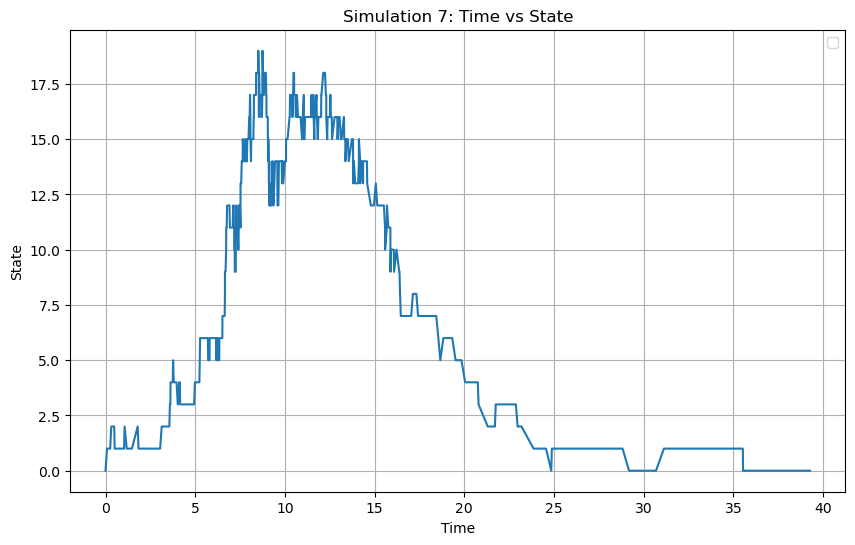

In [29]:
# Open the HDF5 file in read mode
with h5py.File(output_file, 'r') as f:
    # Access the data for simulation 7 (change 'simulation_7' if necessary)
    sim_group = f['simulation_1']  # Replace 'simulation_7' if needed
    t = sim_group['time'][:]  # Extract time data
    y = sim_group['state'][:]  # Extract state data

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, y[:,0,0,3])  # Adjust y[:, 0] to select the relevant state column
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Simulation 7: Time vs State')
plt.legend()
plt.grid(True)
plt.show()